# Tensorflow Hub


This is a common repo like pypi or AUR where we can submit models and browse other models submitted by other people in the community. [TF-Hub](https://tfhub.dev/) is where we can go and browse other models and download them from the hub once we finalize the model.

The models present in tensorflow hub can be categorized in 3 main categories:
- Text
    - Embeddings
- Image
    - Classification
    - Feature Vector
    - Augmentation
    - Object Detection
    - Generator
    - Style Transfer
- Video
    - Classification

In case of Image models, we can either use the `/classification/` form of the model or the `/feature_vector/` form of the model. In the later case we can create our own dense layers on top of the output so as to create our own classifier

## Using Models for Inference

Here we will be using MobileNet module from tensorflow hub for inference

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

### Get the model

In [2]:
!wget -O labels.txt --quiet https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt

In [4]:
with open('saved_model/ImageNet/labels.txt', 'r') as f:
    labels = [l.strip() for l in f.readlines()]
    
num_classes = len(labels)
print('Total number of classes is ', num_classes)

Total number of classes is  1001


In [5]:
MODULE_HANDLE = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4'
module = hub.load(MODULE_HANDLE)

### Getting a testing data

In [14]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [8]:
!wget -O dog.jpeg https://cdn.pixabay.com/photo/2016/12/13/05/15/puppy-1903313_960_720.jpg

--2020-12-28 12:19:49--  https://cdn.pixabay.com/photo/2016/12/13/05/15/puppy-1903313_960_720.jpg
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.21.183, 104.18.20.183, 2606:4700::6812:14b7, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.21.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85624 (84K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>]  83.62K  --.-KB/s    in 0.008s  

2020-12-28 12:19:50 (10.1 MB/s) - ‘dog.jpeg’ saved [85624/85624]



In [10]:
original_image = Image.open('./dog.jpeg')

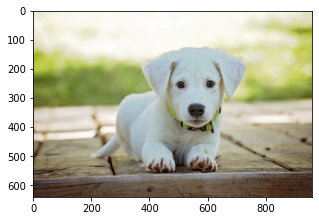

In [13]:
plt.figure(figsize=(5,5))
plt.imshow(original_image)
plt.show()

In [17]:
# as the input image needs to be in dimension 224x224
img = original_image.resize((224, 224))

# normalizing the image
img = np.array(img)/255.0

### Performing Inference

The model doesnt have a softmax function applied to the output of the last result. For this we need to add a softmax layer from our side and then we need to perform the inference

In [18]:
prediction = tf.nn.softmax(module([img]))[0]

In [20]:
top_5_pred_values, top_5_indices = tf.math.top_k(prediction, k=5)

In [21]:
top_5_pred_vales = top_5_pred_values.numpy()
top_5_indices = top_5_indices.numpy()

In [22]:
print(top_5_pred_values)
print(top_5_indices)

tf.Tensor([0.4264827  0.06364429 0.06171353 0.0458611  0.02874688], shape=(5,), dtype=float32)
[209 258 223 853 230]


In [24]:
for value, i in zip(top_5_pred_values, top_5_indices):
    print('{}: {:.3}'.format(labels[i], value))

Labrador retriever: 0.426
Great Pyrenees: 0.0636
kuvasz: 0.0617
tennis ball: 0.0459
Old English sheepdog: 0.0287


As we can see that most of the predictions are regarding dogs and that is what we have passed.

## Using Feature Vector for Transfer Learning

We can use th feature vector output of the model and train our own classifier/dense layers for classification of our choice in place of using the dense layer output as the only result.

Here we will train the Cats vs Dogs classifier using MobileNet_v2

### Getting the data

In [2]:
import tensorflow_datasets as tfds

In [3]:
splits = ['train[:90%]', 'train[90%:]']
splits, info = tfds.load('cats_vs_dogs', split=splits, as_supervised=True, with_info=True)
splits

Dl Completed...: |          | 0/0 [00:00<?, ? url/s]

Dl Size...: |          | 0/0 [00:00<?, ? MiB/s]

  0%|          | 0/1 [00:00<?, ? splits/s]

  0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling and writing examples to /home/sbjr/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteFAFPF7/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /home/sbjr/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


[<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>,
 <PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>]

In [4]:
info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    y

In [5]:
(train_dataset, validation_dataset) = splits

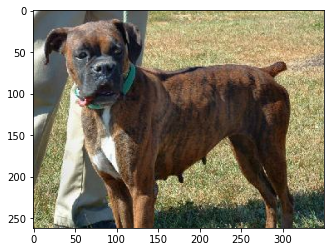

Label is 1


In [7]:
import matplotlib.pyplot as plt

for image, label in train_dataset.take(1):
    plt.imshow(image.numpy())
    plt.show()
    print('Label is {}'.format(label.numpy()))

### Get the Tensorflow Hub feature vector

In [8]:
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
features_extractor = hub.KerasLayer(MODULE_HANDLE, input_shape=(224, 224, 3))

### Build Pipeline

In [9]:
def format_image(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0
    return image, label
    

BATCH_SIZE = 32
SHUFFLE_SIZE = 23262//4
train_dataset = train_dataset.shuffle(SHUFFLE_SIZE).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_dataset = validation_dataset.map(format_image).batch(BATCH_SIZE).prefetch(1)

### Build the Model

In [14]:
# Number of classes in the new dataset
NUM_CLASSES = 2

model = tf.keras.Sequential([
        features_extractor,
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


### Training and Evaluation

In [16]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.fit(train_dataset, epochs=1, validation_data=validation_dataset)

655/655 [==============================] - 71s 90ms/step - loss: 0.0887 - accuracy: 0.9691 - val_loss: 0.0346 - val_accuracy: 0.9884
